# Importing libraries and loading data

In [28]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn import preprocessing
from datetime import datetime as dt
from tensorflow.python import keras 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utils import *

# Defining functions to evaluate and show model graph

In [29]:
def remove_features(df):
    return df.drop(columns=[        
    'device_name',
    'timestamp_until',
    'bike_avg_speed',
    'weather_timestamp',
    'wind_direction',
    'wind_speed',
    'barometer',
    'visibility',
    'Ice fog',
    'Thundershowers',
    'Sprinkles',
    'Broken clouds',
    'Rain showers',
    'Snow flurries',
    'Light fog',
    'Sleet',
    'Cloudy',
    'Quite cool'    
])
def remove_outlier(df_in, col_name):
    """Removes all outliers on a specific column from a given dataframe.

    Args:
        df_in (pandas.DataFrame): Iput pandas dataframe containing outliers
        col_name (str): Column name on which to search outliers

    Returns:
        pandas.DataFrame: DataFrame without outliers
    """         
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1  # Interquartile range
    fence_low = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    return df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)] 
def update_one_hot_data(combined_path,weather_combined_path):
    if not check_if_the_tsv_hot_file_already_has_processed_columns(weather_combined_path):
        df = pd.read_csv(combined_path,
                         sep='\t',
                         header=0) 
        weather_unique_combinations = df.weather_condition.unique()

        #Get list of all unique weather types
        types = []
        for el in weather_unique_combinations:
            for wc in el.split('.'):
                if(wc != ''):            
                    types.append(wc.strip())
        true_unique =  set(types)

        #Add columns with default value 0 for all unique weather types
        for unique_weather_type in true_unique:
            df[unique_weather_type]=0

        #Loop over all records and set value to 1 for their corresponding weather_types
        for index, row in df.iterrows():
            row_types = []
            for wc in row["weather_condition"].split('.'):
                if(wc != ''):            
                    row_types.append(wc.strip())
            for t in row_types:
                df.at[index,t]=1


        #remove empty windspeeds
        df = df[df.wind_speed.apply(lambda x: str(x).isnumeric())]

        #remove original weather_condition column and store, to avoid rerun
        df =  df.drop(columns="weather_condition")
        df.to_csv(weather_combined_path,
                  sep='\t',
                  index=False,
                  header=True)    
    else:
        print("File already processed.")
def evaluate_model_and_show_graph(x_test,y_test,model):
    model.evaluate(x_test, y_test)

    #x_test = x_train
    #y_test = y_train

    #x_test = x_test[14500:]
    #print(x_test)
    #y_test = y_test[14500:]


    y_prediction = model.predict(x_test)
    print(y_prediction)

    y_pred_scaled = y_scaler.inverse_transform(y_prediction)



    y_test_scaled = y_scaler.inverse_transform(y_test)
    mse = mean_squared_error(y_pred_scaled, y_test_scaled)
    mae=mean_absolute_error(y_pred_scaled, y_test_scaled)
    print("MSE: "+str(mse))
    print("MAE: "+str(mae))

    plt.rcParams['figure.figsize'] = [18, 18]
    l1, = plt.plot(y_test_scaled, 'g')
    l2, = plt.plot(y_pred_scaled, 'r', alpha=0.7)
    plt.legend(['Ground truth', 'Predicted'])
    plt.show()

# Loading model

File already processed.
(1451, 47)
We have removed 113 outliers tuples (which is 7.787732598208132 % of total).
(1338, 28)


/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 27)                756       
_________________________________________________________________
dense_1 (Dense)              (None, 14)                392       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 15        
Total params: 1,163
Trainable params: 1,163
Non-trainable params: 0
_________________________________________________________________
1338/1338 [==============================] - 0s 124us/sample - loss: 0.0538 - mean_squared_error: 0.0538 - mean_absolute_error: 0.1827
[[0.21795166]
 [0.4264708 ]
 [0.25510734]
 ...
 [0.00675301]
 [0.20310166]
 [0.11207072]]
MSE: 69.75157395938079
MAE: 6.5775936579134076


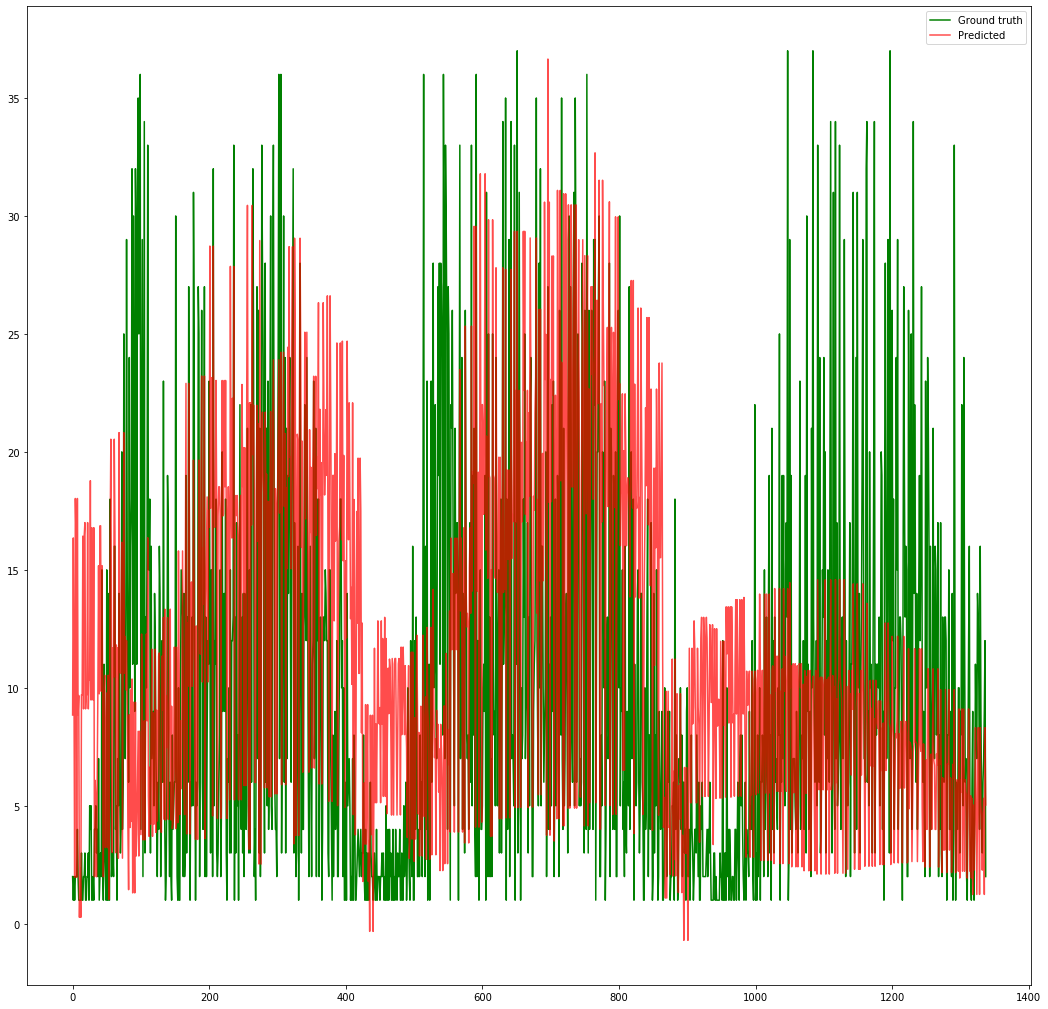

In [30]:
update_one_hot_data('./data/combined_data_22-jun.tsv','./data/combined_data_22-jun_one_hot_data.tsv')
df_new_data = pd.read_csv('./data/combined_data_22-jun_one_hot_data.tsv',
                 sep='\t',
                 header=0)
start_size=df_new_data.shape[0]
print(df_new_data.shape)
df_new_data = remove_outlier(df_new_data, "bike_count")
print("We have removed "+str(start_size-df_new_data.shape[0])+" outliers tuples (which is "+str((start_size-df_new_data.shape[0])/start_size*100)+" % of total).")
df_new_data=remove_features(df_new_data)    
df_new_data.set_index('timestamp_from', inplace=True)
df_new_data = df_new_data.sort_values(by=['timestamp_from'])
print(df_new_data.shape)


#set bike_count as Y
df_y = df_new_data.bike_count
df_x = df_new_data.drop(columns="bike_count")


#Normalization
x = df_x.values
y = df_y.values.reshape(-1, 1)

x_scaler = preprocessing.MinMaxScaler()
x_normalized = x_scaler.fit_transform(x)

y_scaler = preprocessing.MinMaxScaler()
y_normalized = y_scaler.fit_transform(y)

x_in = pd.DataFrame(x_normalized)
y_in = pd.DataFrame(y_normalized)




new_model = keras.models.load_model('./model/model-23-jun.bin')
new_model.summary()
evaluate_model_and_show_graph(x_in,y_in,new_model)
